<h1 style="color:white"><center>Marketing Analytics Project<br>Sentiment Analysis</center></h1>
<h2 style="color:white">Name: Rohit Yadav</h2>
<h2 style="color:white">Section: 004</h2>
<h2 style="color:white">Student Id.: 0790457</h2>

In [1]:
# IMPORTING NECESSARY LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohityadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# READING DATASET

df = pd.read_json('/Users/rohityadav/College-Data/DAB200_PYTHON/Marketing Project/Beauty_5.json', lines=True)

In [32]:
# REVIEWING TOP 3 ROWS OF DATASET

df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"


In [33]:
# REMOVING UNWANTED COLUMNS

df_new = df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1)

In [34]:
# GIVING COLUMNS APPROPRIATE NAMES

df_new.rename({'reviewText' : 'Comment', 'overall' : 'Rating'}, axis=1, inplace=True)

In [35]:
# REVIEWING THE DATASET AFTER MAKING APPROPRIATE CHANGES

df_new.head(3)

,Comment,Rating
0,Very oily and creamy. Not at all what I expect...,1
1,This palette was a decent price and I was look...,3
2,The texture of this concealer pallet is fantas...,4


In [36]:
# CREATING A COLUMN WHICH WILL HAVE THE LENGTH OF EACH REVIEW

df_new['length'] = df_new.Comment.apply(lambda x: len(x))

In [37]:
# CHECKING THE SHAPE

df_new.shape

(198502, 3)

### Checking for class imbalance

<AxesSubplot:xlabel='Rating', ylabel='count'>

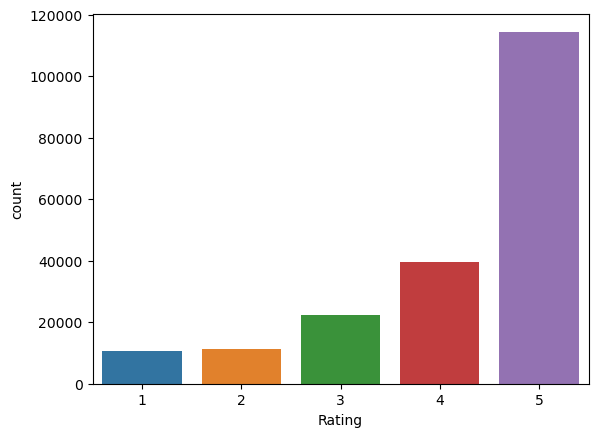

In [38]:
label_count = df_new.groupby(by = df_new.Rating).count()
sns.countplot(data = df_new, x = 'Rating')

#### We can see in the above plot that we have class imbalance in our data, now we will take 10000 reviews from each class 1,2,4,5 and 25000 reviews from class 3.
#### We are taking 20000 reviews from class 3 beacuse we will consider negative review where rating is 1 & 2, neutral where rating is 3, and Positive where rating is 4 & 5 while creating machine learning model.

In [40]:
rating1 = df_new.loc[df_new.Rating==1].sample(10000)
rating2 = df_new.loc[df_new.Rating==2].sample(10000)
rating3 = df_new.loc[df_new.Rating==3].sample(20000)
rating4 = df_new.loc[df_new.Rating==4].sample(10000)
rating5 = df_new.loc[df_new.Rating==5].sample(10000)
beauty = pd.concat([rating1,rating2,rating3,rating4,rating5])

#### We can see in the below plot that class imbalance issue is fixed now.

##### The reason we have taken more reviews for rating 3 is discussed above.

<AxesSubplot:xlabel='Rating', ylabel='count'>

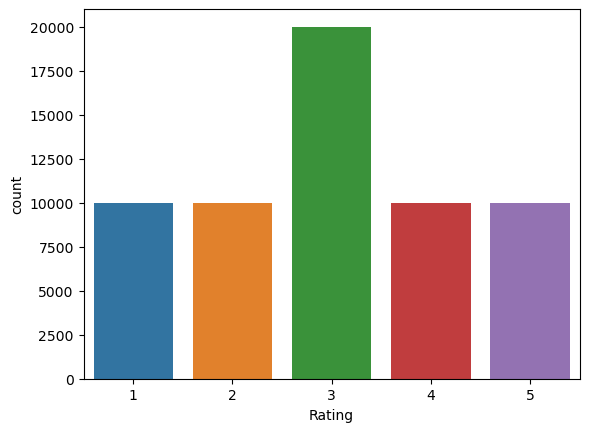

In [41]:
label_count = beauty.groupby(by = beauty.Rating).count()
sns.countplot(data = beauty, x = 'Rating')

### Preprocessing Steps

In [42]:
# STORING A COPY OF BEAUTY IN BEAUTY_ML WHICH I WILL USE LATER FOR TESTING PURPOSE 

beauty_ml = beauty.copy()

In [43]:
# IN THIS STEP WE WILL CREATE A FUNCTION TO REMOVE PUNCHUATION, WHITESPACES, DIGITS, AND SPECIAL CHARACTERS FROM THE COMMENTS COLUMN.
# THIS FUNCTION WILL ALSO DO STEMMING OF WORDS

ps = PorterStemmer()
remove_digits = str.maketrans('', '', string.digits)
def preprocessor(review):
    review = review.lower()
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.translate(remove_digits)
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
    comment = list(set(review))
    return comment

In [44]:
# APPLYING THE FUNCTION TO EVERY ROW IN COMMENTS COLUMN

beauty['Comment'] = beauty['Comment'].apply(lambda x: preprocessor(x))

In [45]:
# CHECKING FOR NULL VALUES

beauty.isnull().sum().to_frame

<bound method Series.to_frame of Comment    0
Rating     0
length     0
dtype: int64>

In [46]:
# HERE WE ARE CHECKING FOR NUMBER OF OBSERVATION THAT WE HAVE CORROSPONDING EACH CLASS

beauty[['Comment']].groupby(by = beauty.Rating).count()

,Comment
Rating,
1,10000
2,10000
3,20000
4,10000
5,10000


<h3>Below we have created five empty list corrosponding to each rating and a function which will take empty list and rating as an input and afterwards it will add all the comments corrosponding to that rating to the empty list.</h3>

In [47]:
wordlist1, wordlist2, wordlist3, wordlist4, wordlist5 = [], [], [], [], []       # ASSIGNING EMPTY LIST
def string_concat(wordlist, rating):
    for i in beauty.loc[beauty.Rating == rating].Comment.values:
        wordlist +=i
string_concat(wordlist1, 1)
string_concat(wordlist2, 2)
string_concat(wordlist3, 3)
string_concat(wordlist4, 4)
string_concat(wordlist5, 5)

In [48]:
# BELOW WE ARE CONVERTING THE LIST TO NUMPY ARRAYS FOR FASTER COMPUTATION

wordlist1 = np.array(wordlist1)
wordlist2 = np.array(wordlist2)
wordlist3 = np.array(wordlist3)
wordlist4 = np.array(wordlist4)
wordlist5 = np.array(wordlist5)

### Below we are creating 5 empty dictionaries and a function that will take the empty dictionary and the word list as a input and will calculate the word count in that list and add it to the dictionary.

In [49]:
wordcount1, wordcount2, wordcount3, wordcount4, wordcount5 = {}, {}, {}, {}, {}
def wordcount(wordlist, dictionary):
    for i in wordlist:
        if i not in dictionary.keys():
            dictionary[i] = wordlist[wordlist == i].shape[0]
wordcount(wordlist1, wordcount1)
wordcount(wordlist2, wordcount2)
wordcount(wordlist3, wordcount3)
wordcount(wordlist4, wordcount4)
wordcount(wordlist5, wordcount5)

In [50]:
#CONVERTING THE DICTIONARIES INTO PANDAS DATAFRAME

wordcount1_df = pd.DataFrame([wordcount1])
wordcount2_df = pd.DataFrame([wordcount2])
wordcount3_df = pd.DataFrame([wordcount3])
wordcount4_df = pd.DataFrame([wordcount4])
wordcount5_df = pd.DataFrame([wordcount5])

In [51]:
# CREATING A FUNCTION TO TRANSPOSE THE DATASET

def transpose(wordcount):
    return wordcount.transpose().reset_index().rename(columns={'index':'Word', 0:'Count'})
wordcount1_df = transpose(wordcount1_df)
wordcount2_df = transpose(wordcount2_df)
wordcount3_df = transpose(wordcount3_df)
wordcount4_df = transpose(wordcount4_df)
wordcount5_df = transpose(wordcount5_df)

In [52]:
#REMOVING ALL THE WORDS WHOSE COUNT ARE LESS THAN OR EQUAL TO ONE, THIS WILL ALSO REMOVE THE EMPTY STRINGS

wordcount1_final = wordcount1_df.loc[wordcount1_df.Count > 1]
wordcount2_final = wordcount2_df.loc[wordcount2_df.Count > 1]
wordcount3_final = wordcount3_df.loc[wordcount3_df.Count > 1]
wordcount4_final = wordcount4_df.loc[wordcount4_df.Count > 1]
wordcount5_final = wordcount5_df.loc[wordcount5_df.Count > 1]

### Now we will create wordcloud plots to get better understandig of all words that are present in different class.

In [53]:
#CREATIGN A FUCNTION TO CREATE WORDCLOUD.

def word_cloud(df):
    text = ' '.join([word for word in df.Word])    
    word_cloud = WordCloud(collocations=False, background_color = 'white').generate(text)
    plt.figure(figsize=(8,6))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Below is the wordcloud for words corrosponding to rating 1.

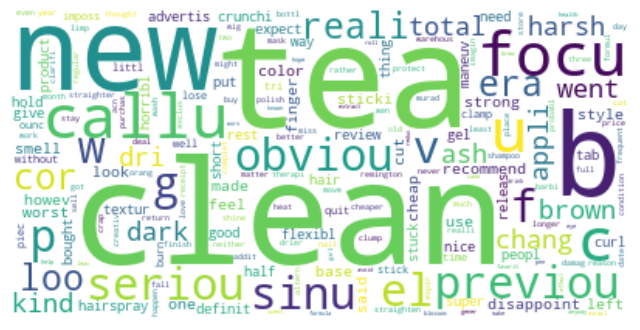

In [54]:
word_cloud(wordcount1_final)

### Below is the wordcloud for words corrosponding to rating 2.

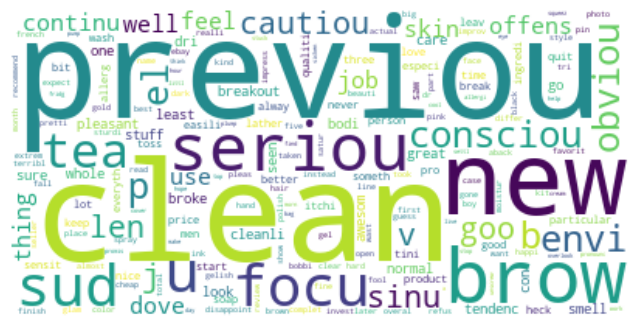

In [55]:
word_cloud(wordcount2_final)

### Below is the wordcloud for words corrosponding to rating 3.

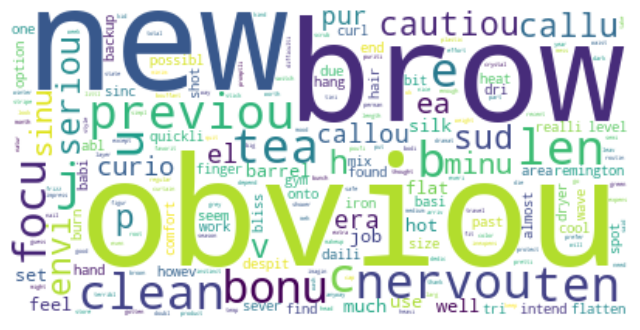

In [56]:
word_cloud(wordcount3_final)

### Below is the wordcloud for words corrosponding to rating 4.

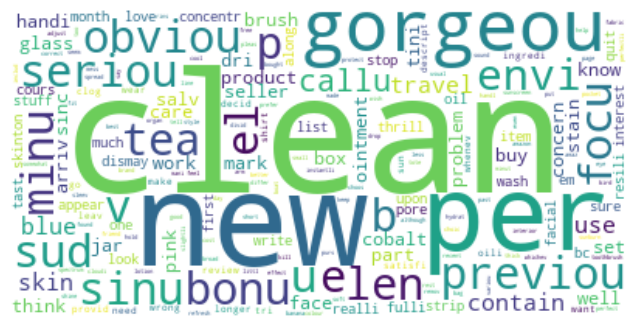

In [57]:
word_cloud(wordcount4_final)

### Below is the wordcloud for words corrosponding to rating 5.

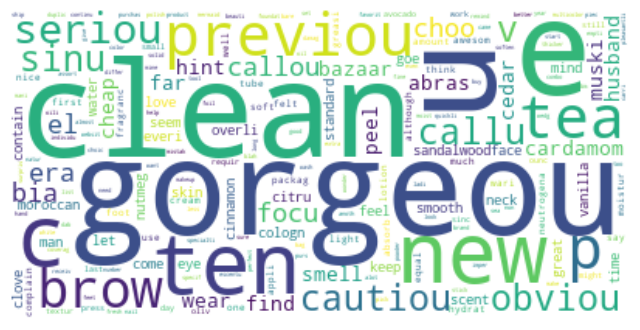

In [58]:
word_cloud(wordcount5_final)

## Now we will start creating deep learning model using tensorflow & keras

In [70]:
# CREATING MULTIPLE TEXT VECTORIZATION LAYERS FOR TESTING

max_tokens = 30000
output_sequence = 300
text_vectorization_unigram_int = TextVectorization(max_tokens = max_tokens,
                                                   output_mode = 'int', 
                                                   output_sequence_length = output_sequence)

text_vectorization_unigram_binary = TextVectorization(max_tokens = max_tokens,
                                                      output_mode = 'binary')

text_vectorization_unigram_tf_idf = TextVectorization(max_tokens = max_tokens,
                                                      output_mode = 'tf-idf')

text_vectorization_bigram_int = TextVectorization(ngrams = 2,
                                                  max_tokens = max_tokens,
                                                  output_mode = 'int',
                                                  output_sequence_length = output_sequence)

text_vectorization_bigram_binary = TextVectorization(ngrams = 2,
                                                     max_tokens = max_tokens,
                                                     output_mode = 'binary')

text_vectorization_bigram_tf_idf = TextVectorization(ngrams = 2,
                                                     max_tokens = max_tokens,
                                                     output_mode = 'tf-idf')

In [95]:
# DEFINING FUNCTION TO CREATE INPUT PIPELINE USING TENSORFLOW

def input_pipeline(train, val, train_label, val_label, text_vectorization):
    with tf.device('/cpu:0'):
        text_vectorization.adapt(train.to_numpy())
    train_label_cat = to_categorical(train_label)
    val_label_cat = to_categorical(val_label)
    train_ds = tf.data.Dataset.from_tensor_slices((train, train_label_cat))
    val_ds = tf.data.Dataset.from_tensor_slices((val, val_label_cat))
    train_ds_int = train_ds.map(lambda x,y: (text_vectorization(x), y))
    val_ds_int = val_ds.map(lambda x,y: (text_vectorization(x), y))
    train_ds_batch = train_ds_int.shuffle(1000).batch(32)
    val_ds_batch = val_ds_int.shuffle(1000).batch(32)
    print(f'Vocabulary length for {text_vectorization} is {len(text_vectorization.get_vocabulary())}')
    return train_ds_batch, val_ds_batch

In [102]:
# DEFINING MODELS

# 1--MODEL TO BE USED FOR INT VECTORIZATION

def model_int():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = keras.layers.Embedding(input_dim=30000, output_dim=256)(inputs)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedded)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(3, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# 2--MODEL FOR BINARY AND TF_IDF VECTORIZATION

def model_binary_tfidf():
    inputs = keras.Input(shape=(30000,))
    x = keras.layers.Dense(64, activation="relu")(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

#### WE WILL NOW CONVERT THE CLASSES
##### 1 & 2 = 0 WHICH IS NEGATIVE REVIEW
##### 3 = 1 WHICH IS NEUTRAL REVIEW
##### 4 & 5 = 2 WHICH IS POSITIVE REVIEW

In [ ]:
beauty_ml['Rating'].mask(beauty_ml.Rating==1, 0, inplace=True)
beauty_ml['Rating'].mask(beauty_ml.Rating==2, 0, inplace=True)
beauty_ml['Rating'].mask(beauty_ml.Rating==3, 1, inplace=True)
beauty_ml['Rating'].mask(beauty_ml.Rating==4, 2, inplace=True)
beauty_ml['Rating'].mask(beauty_ml.Rating==5, 2, inplace=True)

In [91]:
#CHECKGIN THE VALUE COUNTS

print(beauty_ml.Rating.value_counts())

0    20000
1    20000
2    20000
Name: Rating, dtype: int64
0    20000
1    20000
2    20000
Name: Rating, dtype: int64


### We will test with data which was not pre processed and let text vectorization layer handel the pre processing part.

In [107]:
# DROPING COMMENTS WITH LENGTH LESS THAN 10
beauty_ml.reset_index(inplace=True)
for enm,i in enumerate(beauty_ml.Comment):
    if len(i)<10:
        beauty_ml.drop([enm], axis=0, inplace=True)

In [108]:
#CREATING FEATURE AND TARGET VARIABLE
X = beauty_ml['Comment']
y = beauty_ml['Rating']

In [109]:
# SPLITTING THE DATA INTO RAINING AND VALIDATION SET

train, val, train_label, val_label = train_test_split(X, y, test_size = 0.30, stratify = y)

### Training with unigram

In [110]:
train_ds_batch_int, val_ds_batch_int = input_pipeline(train, val, train_label, val_label, text_vectorization_unigram_int)
train_ds_batch_binary, val_ds_batch_binary = input_pipeline(train, val, train_label, val_label, text_vectorization_unigram_binary)
train_ds_batch_tfidf, val_ds_batch_tfidf = input_pipeline(train, val, train_label, val_label, text_vectorization_unigram_tf_idf)

Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x4ff671850> is 30000
Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x50ac2dc40> is 30000
Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x4fafb8eb0> is 30000


#### Training with unigram int

In [111]:
model = model_int()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         7680000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 7,754,179
Trainable params: 7,754,179
Non-trainable params: 0
_________________________________________________

In [112]:
history_unigram_int = model.fit(train_ds_batch_int.cache(),
                                  validation_data=val_ds_batch_int.cache(),
                                  epochs=10,
                                  verbose=1)

Epoch 1/10


2022-12-06 00:04:29.867141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:04:30.103714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:04:30.116168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:04:30.897797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:04:30.919470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.5793

2022-12-06 00:08:40.529394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:08:40.681492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 00:08:40.694585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 296s 223ms/step - loss: 0.5309 - accuracy: 0.5793 - val_loss: 0.4705 - val_accuracy: 0.6463
Epoch 2/10
1312/1312 [==============================] - 271s 206ms/step - loss: 0.4534 - accuracy: 0.6743 - val_loss: 0.4581 - val_accuracy: 0.6545
Epoch 3/10
1312/1312 [==============================] - 264s 201ms/step - loss: 0.4166 - accuracy: 0.7100 - val_loss: 0.4629 - val_accuracy: 0.6622
Epoch 4/10
1312/1312 [==============================] - 263s 201ms/step - loss: 0.3839 - accuracy: 0.7434 - val_loss: 0.4674 - val_accuracy: 0.6673
Epoch 5/10
1312/1312 [==============================] - 268s 204ms/step - loss: 0.3517 - accuracy: 0.7703 - val_loss: 0.4831 - val_accuracy: 0.6613
Epoch 6/10
1312/1312 [==============================] - 265s 202ms/step - loss: 0.3178 - accuracy: 0.7980 - val_loss: 0.4791 - val_accuracy: 0.6662
Epoch 7/10
1312/1312 [==============================] - 270s 205ms/step - loss: 0.2850 - accuracy: 0.8236 - val_loss: 0.571

#### Training with unigram binary

In [113]:
model = model_binary_tfidf()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_2 (Dense)             (None, 64)                1920064   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,924,419
Trainable params: 1,924,419
Non-tra

In [114]:
callbacks = keras.callbacks.ModelCheckpoint("unigram_binary.keras",
                                             save_best_only=True)
history_unigram_binary = model.fit(train_ds_batch_binary.cache(),
                                  validation_data=val_ds_batch_binary.cache(),
                                  epochs=10,
                                  verbose=1,
                                  callbacks=[callbacks])

Epoch 1/10


2022-12-06 00:50:32.160764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.6292

2022-12-06 00:51:01.892775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 39s 29ms/step - loss: 0.4921 - accuracy: 0.6292 - val_loss: 0.4569 - val_accuracy: 0.6634
Epoch 2/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.3919 - accuracy: 0.7285 - val_loss: 0.4761 - val_accuracy: 0.6601
Epoch 3/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.3273 - accuracy: 0.7871 - val_loss: 0.5316 - val_accuracy: 0.6589
Epoch 4/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.2680 - accuracy: 0.8359 - val_loss: 0.6057 - val_accuracy: 0.6545
Epoch 5/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.2176 - accuracy: 0.8714 - val_loss: 0.7176 - val_accuracy: 0.6484
Epoch 6/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.1769 - accuracy: 0.9002 - val_loss: 0.8686 - val_accuracy: 0.6442
Epoch 7/10
1312/1312 [==============================] - 19s 14ms/step - loss: 0.1443 - accuracy: 0.9211 - val_loss: 1.0599 - val_accura

#### Training with unigram tf_idf

In [115]:
model = model_binary_tfidf()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_5 (Dense)             (None, 64)                1920064   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,924,419
Trainable params: 1,924,419
Non-tra

In [117]:
callbacks = keras.callbacks.ModelCheckpoint("unigram_tf_idf.keras",
                                             save_best_only=True)
history_unigram_tf_idf = model.fit(train_ds_batch_tfidf.cache(),
                                  validation_data=val_ds_batch_tfidf.cache(),
                                  epochs=10,
                                  verbose=1,
                                  callbacks=[callbacks])

Epoch 1/10


2022-12-06 00:56:09.221359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.6253

2022-12-06 00:56:38.103933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 38s 28ms/step - loss: 0.5051 - accuracy: 0.6253 - val_loss: 0.4581 - val_accuracy: 0.6671
Epoch 2/10
1312/1312 [==============================] - 19s 14ms/step - loss: 0.3682 - accuracy: 0.7555 - val_loss: 0.4916 - val_accuracy: 0.6583
Epoch 3/10
1312/1312 [==============================] - 18s 14ms/step - loss: 0.2721 - accuracy: 0.8333 - val_loss: 0.5642 - val_accuracy: 0.6505
Epoch 4/10
1312/1312 [==============================] - 18s 14ms/step - loss: 0.2003 - accuracy: 0.8846 - val_loss: 0.6520 - val_accuracy: 0.6410
Epoch 5/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1472 - accuracy: 0.9200 - val_loss: 0.7782 - val_accuracy: 0.6359
Epoch 6/10
1312/1312 [==============================] - 18s 14ms/step - loss: 0.1093 - accuracy: 0.9422 - val_loss: 0.9374 - val_accuracy: 0.6329
Epoch 7/10
1312/1312 [==============================] - 18s 14ms/step - loss: 0.0814 - accuracy: 0.9586 - val_loss: 1.1393 - val_accura

### Training with bigram

In [118]:
train_ds_batch_bi_int, val_ds_batch_bi_int = input_pipeline(train, val, train_label, val_label, text_vectorization_bigram_int)
train_ds_batch_bi_binary, val_ds_batch_bi_binary = input_pipeline(train, val, train_label, val_label, text_vectorization_bigram_binary)
train_ds_batch_bi_tfidf, val_ds_batch_bi_tfidf = input_pipeline(train, val, train_label, val_label, text_vectorization_bigram_tf_idf)

2022-12-06 01:03:16.212763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x4ffaea700> is 30000


2022-12-06 01:03:19.800844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x4ffae5250> is 30000


2022-12-06 01:03:22.675600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Vocabulary length for <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x4ffaea760> is 30000


#### Training with bigram int

In [119]:
model = model_int()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         7680000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 7,754,179
Trainable params: 7,754,179
Non-trainable params: 0
_________________________________________________

In [121]:
warnings.filterwarnings('ignore')
callbacks = keras.callbacks.ModelCheckpoint("2gram_int.keras",
                                             save_best_only=True)
history_bigram_int = model.fit(train_ds_batch_bi_int.cache(),
                                  validation_data=val_ds_batch_bi_int.cache(),
                                  epochs=10,
                                  verbose=1,
                                  callbacks=[callbacks])

Epoch 1/10


2022-12-06 01:03:36.947227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:03:37.189851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:03:37.206693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:03:38.322174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:03:38.349200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.5866

2022-12-06 01:07:54.682555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:07:54.857461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 01:07:54.867217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 306s 230ms/step - loss: 0.5252 - accuracy: 0.5866 - val_loss: 0.4675 - val_accuracy: 0.6490
Epoch 2/10
1312/1312 [==============================] - 258s 196ms/step - loss: 0.4339 - accuracy: 0.7011 - val_loss: 0.4578 - val_accuracy: 0.6729
Epoch 3/10
1312/1312 [==============================] - 252s 192ms/step - loss: 0.3696 - accuracy: 0.7610 - val_loss: 0.4680 - val_accuracy: 0.6664
Epoch 4/10
1312/1312 [==============================] - 261s 199ms/step - loss: 0.3047 - accuracy: 0.8154 - val_loss: 0.5250 - val_accuracy: 0.6574
Epoch 5/10
1312/1312 [==============================] - 273s 208ms/step - loss: 0.2482 - accuracy: 0.8588 - val_loss: 0.5767 - val_accuracy: 0.6417
Epoch 6/10
1312/1312 [==============================] - 279s 212ms/step - loss: 0.2045 - accuracy: 0.8882 - val_loss: 0.6421 - val_accuracy: 0.6456
Epoch 7/10
1312/1312 [==============================] - 279s 212ms/step - loss: 0.1703 - accuracy: 0.9099 - val_loss: 0.695

#### Training with bigram binary

In [122]:
model = model_binary_tfidf()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_9 (Dense)             (None, 64)                1920064   
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,924,419
Trainable params: 1,924,419
Non-tra

In [123]:
callbacks = keras.callbacks.ModelCheckpoint("2gram_binary.keras",
                                             save_best_only=True)
history_bigram_binary = model.fit(train_ds_batch_bi_binary.cache(),
                                  validation_data=val_ds_batch_bi_binary.cache(),
                                  epochs=10,
                                  verbose=1,
                                  callbacks=[callbacks])

Epoch 1/10


2022-12-06 01:52:54.375129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.6619

2022-12-06 01:53:26.919610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 42s 30ms/step - loss: 0.4653 - accuracy: 0.6619 - val_loss: 0.4209 - val_accuracy: 0.7038
Epoch 2/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.2955 - accuracy: 0.8131 - val_loss: 0.4677 - val_accuracy: 0.6969
Epoch 3/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.1892 - accuracy: 0.8916 - val_loss: 0.5612 - val_accuracy: 0.6942
Epoch 4/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.1195 - accuracy: 0.9385 - val_loss: 0.7109 - val_accuracy: 0.6876
Epoch 5/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0748 - accuracy: 0.9630 - val_loss: 1.0212 - val_accuracy: 0.6661
Epoch 6/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0477 - accuracy: 0.9786 - val_loss: 1.2726 - val_accuracy: 0.6785
Epoch 7/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0294 - accuracy: 0.9877 - val_loss: 1.6984 - val_accura

#### Training with bigram tf_idf

In [124]:
model = model_binary_tfidf()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_12 (Dense)            (None, 64)                1920064   
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,924,419
Trainable params: 1,924,419
Non-tra

In [125]:
callbacks = keras.callbacks.ModelCheckpoint("2gram_tf_idf.keras",
                                             save_best_only=True)
history_bigram_tf_idf = model.fit(train_ds_batch_bi_tfidf.cache(),
                                  validation_data=val_ds_batch_bi_tfidf.cache(),
                                  epochs=10,
                                  verbose=1,
                                  callbacks=[callbacks])

Epoch 1/10


2022-12-06 01:57:25.623567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.6346

2022-12-06 01:57:56.347025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1312/1312 [==============================] - 40s 29ms/step - loss: 0.5012 - accuracy: 0.6346 - val_loss: 0.4264 - val_accuracy: 0.7041
Epoch 2/10
1312/1312 [==============================] - 20s 15ms/step - loss: 0.3130 - accuracy: 0.8021 - val_loss: 0.4689 - val_accuracy: 0.6951
Epoch 3/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.1877 - accuracy: 0.8942 - val_loss: 0.5797 - val_accuracy: 0.6808
Epoch 4/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.1120 - accuracy: 0.9417 - val_loss: 0.7157 - val_accuracy: 0.6671
Epoch 5/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0691 - accuracy: 0.9643 - val_loss: 0.8753 - val_accuracy: 0.6638
Epoch 6/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0456 - accuracy: 0.9772 - val_loss: 1.1208 - val_accuracy: 0.6573
Epoch 7/10
1312/1312 [==============================] - 19s 15ms/step - loss: 0.0319 - accuracy: 0.9850 - val_loss: 1.3950 - val_accura

### Performance Comparision of unigrams

In [1]:
def comparison_plot(history_int, history_binary, history_tf_idf):
    accuracy = history_int.history["accuracy"]
    val_accuracy = history_int.history["val_accuracy"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()


    accuracy = history_binary.history["accuracy"]
    val_accuracy = history_binary.history["val_accuracy"]

    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation accuracy")
    plt.legend()

    accuracy = history_tf_idf.history["accuracy"]
    val_accuracy = history_tf_idf.history["val_accuracy"]

    plt.subplot(1, 3, 3)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

### COMPARISION OF UNIGRAM

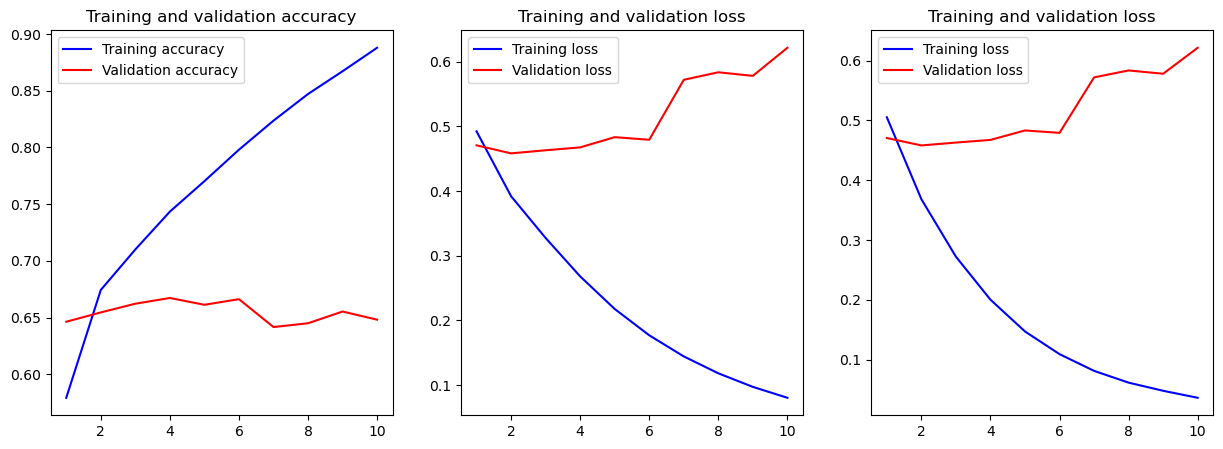

In [135]:
comparison_plot(history_unigram_int, history_unigram_binary, history_unigram_tf_idf)

### COMPARISION OF BIGRAM

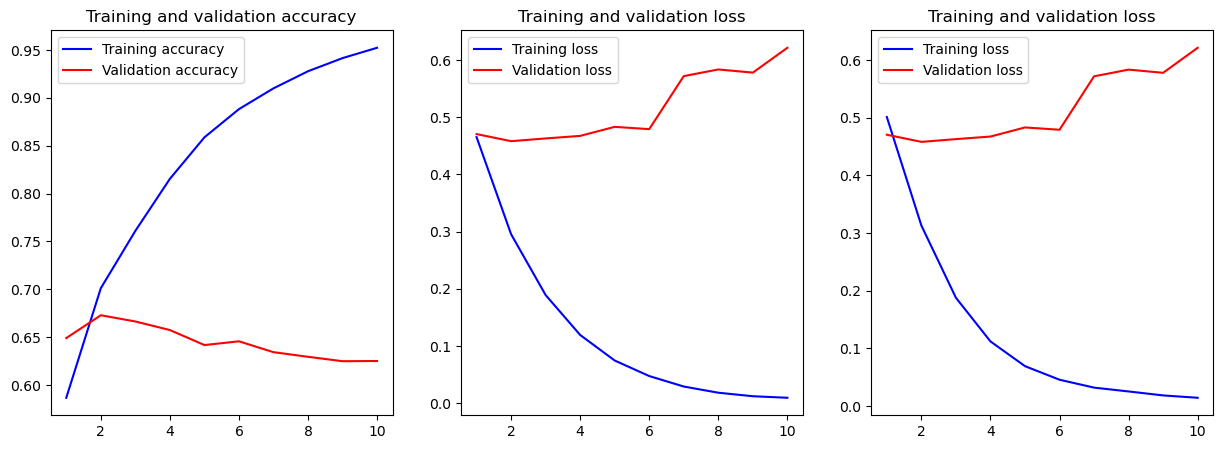

In [136]:
comparison_plot(history_bigram_int, history_bigram_binary, history_bigram_tf_idf)

# CONCLUSION

We have tried multiple techniques for analysis which includes unigram tokens, bigram tokens, and different types of tokenization technique such as integer, binary, and tf-idf. After trying multiple techniques we can go forward with sequence model using unigram integer tokenization technique and passing it through embedding layer with 256 output sequence and a bidirectional LSTM layer. The training accuracy is good whereas the validation accuracy is not that much good when compared to training. I have tried lot of other techniques including pre trained word embedding, increasing and decreasing the number of neuron and using kernel regularizers in other notebooks but the highest validation accuracy I got is around 66%. The dataset has lot of variations in reviews because of which validation accuracy is struggling. In the end I would like to conclude that we can go ahead with the sequence model.
<h3>Future Scope:</h3> We can add more accurate and evenly distributed data to our dataset and make our model more robust. Afterwards, we can go ahead and integrate the model into web application for better user experience.